In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ['TORCHDYNAMO_VERBOSE'] = "1"

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision.models.detection import fasterrcnn_mobilenet_v3_large_fpn, FasterRCNN_MobileNet_V3_Large_FPN_Weights, fasterrcnn_resnet50_fpn_v2, FasterRCNN_ResNet50_FPN_Weights
from torchvision.models import MobileNet_V3_Large_Weights, ResNet50_Weights
from torchvision.models.detection.rpn import concat_box_prediction_layers
from torchvision.models.detection.roi_heads import fastrcnn_loss
from torchvision import ops as tv_ops

import numpy as np
import random
import math
from pathlib import Path
from fastai.vision import *
import lightning as L
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.callbacks import RichProgressBar, ModelCheckpoint, EarlyStopping, LearningRateMonitor, RichModelSummary
import cv2
from pycocotools import coco, cocoeval, _mask
from pycocotools import mask as maskUtils
from PIL import  Image
from matplotlib import pyplot as plt
import logging
import sys
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

logging.basicConfig(stream=sys.stdout, level=logging.DEBUG)
logger = logging.getLogger("trainer")
torch.set_float32_matmul_precision('medium')
torch.backends.cudnn.benchmark = True
# logger.setLevel(logging.DEBUG)

In [2]:
import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
# os.environ['TORCHDYNAMO_VERBOSE'] = "1"

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision.models.detection import fasterrcnn_mobilenet_v3_large_fpn, FasterRCNN_MobileNet_V3_Large_FPN_Weights, fasterrcnn_resnet50_fpn_v2, FasterRCNN_ResNet50_FPN_Weights
from torchvision.models import MobileNet_V3_Large_Weights, ResNet50_Weights
from torchvision.models.detection.rpn import concat_box_prediction_layers
from torchvision.models.detection.roi_heads import fastrcnn_loss

from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from PIL import Image

import numpy as np
import random
import math
from pathlib import Path
from fastai.vision import *
import lightning as L
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.callbacks import RichProgressBar, ModelCheckpoint, EarlyStopping, LearningRateMonitor, RichModelSummary
import cv2
from pycocotools import coco, cocoeval, _mask
from pycocotools import mask as maskUtils
from PIL import  Image
from matplotlib import pyplot as plt
import logging
import sys
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from torchmetrics.text import CharErrorRate
from fastprogress.fastprogress import master_bar, progress_bar
import copy

import json

from typing import List, Optional, Union, Tuple, Dict, Any

logging.basicConfig(stream=sys.stdout, level=logging.DEBUG)
logger = logging.getLogger("trainer")
torch.set_float32_matmul_precision('medium')
torch.backends.cudnn.benchmark = True
# torch.autograd.set_detect_anomaly(True)
# logger.setLevel(logging.DEBUG)

In [3]:
class FasterRCNNModel(object):
    def __init__(self, weights, num_classes, device, transform=None):
        self.weights = weights
        self.num_classes = num_classes
        self.device = device

        self.model = None
        # self.model = self.build_model()
        # self.model.eval().to(self.device)

        self.transform = transform

    def load_model(self, weights=None):
        
        logger.debug("Loading FasterRCNNModel")
        if weights is None:
            if self.weights is None:
                raise Exception("Weights not provided")
            else:
                weights = self.weights
        
        if isinstance(weights, str) or isinstance(weights, Path):
            state_dict = torch.load(weights)
        else:
            state_dict = weights

        logger.debug("Loading FasterRCNNModel weights")
        model = fasterrcnn_resnet50_fpn_v2(weights=None, num_classes=self.num_classes)
        model.load_state_dict(state_dict)

        self.model = model
        self.model.eval().to(self.device)

        logger.debug("FasterRCNNModel loaded")

        return model
    
    def predict(self, image, class_num=2, iou_threshold=0.5, score_threshold=0.5) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        
        if self.model is None:
            raise Exception("Model not loaded")

        with torch.no_grad():
            image = self.transform(image=image)['image']
            # image = image.unsqueeze(0)
            image = torch.from_numpy(image)
            image = image.permute(2, 0, 1).to(self.device)/255.
            image = image.unsqueeze(0)

            with torch.no_grad():
                pred = self.model(image)
            pred = pred[0]

            nms_indexes = tv_ops.batched_nms(pred["boxes"], pred["scores"], pred["labels"], iou_threshold=iou_threshold)

            bboxes = torch.index_select(input=pred["boxes"], index=nms_indexes, dim=0)
            labels = torch.index_select(input=pred["labels"], index=nms_indexes, dim=0)
            scores = torch.index_select(input=pred["scores"], index=nms_indexes, dim=0)

            bboxes = torch.index_select(bboxes, index=torch.where(labels == class_num)[0], dim=0)
            labels = torch.index_select(labels, index=torch.where(labels == class_num)[0], dim=0)
            scores = torch.index_select(scores, index=torch.where(labels == class_num)[0], dim=0)

            bboxes = torch.index_select(bboxes, index=torch.where(scores > 0.5)[0], dim=0)
            labels = torch.index_select(labels, index=torch.where(scores > 0.5)[0], dim=0)
            scores = torch.index_select(scores, index=torch.where(scores > 0.5)[0], dim=0)

            pred_boxes = bboxes.cpu().numpy()
            pred_scores = scores.cpu().numpy()
            pred_labels = labels.cpu().numpy()
            
            
        return pred_boxes, pred_scores, pred_labels
        

class TrOCRModel(object):
    def __init__(self, weights=None, device=None, hf_model_name=None):
        self.weights = weights
        self.device = device
        self.hf_model_name = hf_model_name

        if self.hf_model_name is None:
            raise Exception("hf_model_name not provided")

        self.model: VisionEncoderDecoderModel = None
        self.processor: TrOCRProcessor = None

        # self.model = self.build_model()
        # self.model.eval().to(self.device)

    def load_model(self, weights=None):

        logger.debug("Loading TrOCRModel")

        if weights is None:
            if self.weights is None:
                raise Exception("Weights not provided")
            else:
                weights = self.weights
        
        if isinstance(weights, str) or isinstance(weights, Path):
            state_dict = torch.load(weights)
        else:
            state_dict = weights
        
        model = VisionEncoderDecoderModel.from_pretrained(self.hf_model_name).to(self.device)
        processor = TrOCRProcessor.from_pretrained(self.hf_model_name)

        model.config.decoder_start_token_id = processor.tokenizer.sep_token_id
        model.config.pad_token_id = processor.tokenizer.pad_token_id
        model.config.vocab_size = model.config.decoder.vocab_size
        model.config.eos_token_id = processor.tokenizer.sep_token_id
        model.config.bos_token_id = processor.tokenizer.cls_token_id
        model.config.max_length = 10

        model = torch.compile(model)
        # model.half()
        model.eval()


        logger.debug("Loading TrOCRModel weights")
        model.load_state_dict(state_dict)
        

        self.model = model
        self.processor = processor

        logger.debug("TrOCRModel loaded")

        return model, processor
    
    def postprocess_text(self, text: str):
        text = ''.join(filter(str.isdigit, text))
        return text
    
    def predict(self, image) -> str:
            
        if self.model is None:
            raise Exception("Model not loaded")
        
        if self.processor is None:
            raise Exception("Processor not loaded")

        with torch.no_grad():
            pixel_values = self.processor(image, return_tensors="pt").pixel_values
            pixel_values = pixel_values.to(self.device)
            # pixel_values.half()
            # pixel_values = pixel_values.unsqueeze(0)

            logger.debug(f"{pixel_values.shape}")

            generated_ids = self.model.generate(pixel_values, max_new_tokens=100)
            generated_text = self.processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
            logger.debug(f"Generated text: {generated_text}")
            generated_text = self.postprocess_text(generated_text)

        
        return generated_text

            
    


In [4]:
class Inference(object):
    def __init__(self, device):
        self.device = device
        
        self.detection_model: FasterRCNNModel = None
        self.ocr_model: TrOCRModel = None

    def load_detection_model(self, weights, num_classes, transform=None):
        self.detection_model = FasterRCNNModel(weights, num_classes, self.device, transform)
        self.detection_model.load_model()

    def load_ocr_model(self, weights, hf_model_name=None):
        self.ocr_model = TrOCRModel(weights, self.device, hf_model_name)
        self.ocr_model.load_model()

    def predict(self, image: Image, class_num=2, iou_threshold=0.5, score_threshold=0.5):

        image_array = np.array(image)

        pred_boxes, pred_scores, pred_labels = self.detection_model(image_array, class_num, iou_threshold, score_threshold)
        
        highest_score_index = np.argmax(pred_scores)
        
        pred_boxes = pred_boxes[highest_score_index]
        pred_scores = pred_scores[highest_score_index]
        pred_labels = pred_labels[highest_score_index]

        bbox = pred_boxes

        odometer_image = image.crop(bbox)
        odometer_image = odometer_image.convert('RGB')

        pred_text = self.ocr_model.predict(image)

        return pred_boxes, pred_scores, pred_labels, pred_text
    

In [5]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_CLASSES = 3
HF_MODEL_NAME = "microsoft/trocr-large-stage1"

transform = A.Compose([
    A.Resize(720, 1280),
])

inference = Inference(DEVICE)
# inference.load_detection_model("weights/fasterrcnn/fasterrcnn-resnet50.pt", num_classes=3, transform=transform)
# inference.load_ocr_model("weights/trocr/trocr.pt", hf_model_name=HF_MODEL_NAME)



In [6]:
detection_inference = FasterRCNNModel("weights/fasterrcnn/fasterrcnn-resnet50.pt", num_classes=3, device=DEVICE, transform=transform)
_ = detection_inference.load_model()

DEBUG:trainer:Loading FasterRCNNModel
DEBUG:trainer:Loading FasterRCNNModel weights
DEBUG:trainer:FasterRCNNModel loaded


In [7]:
image = Image.open("dataset/test/62a501c62be4ea4a151632ba/scraped_XKeC0o_1654878963655.jpg")
image = image.resize((1280, 720))

# inference.predict(image)

image_array = np.array(image)

pred_boxes, pred_scores, pred_labels = detection_inference.predict(image_array, class_num=2, iou_threshold=0.5, score_threshold=0.5)


In [8]:
trocr_inference = TrOCRModel("weights/trocr/trocr_test.pt", device=DEVICE, hf_model_name=HF_MODEL_NAME)
_ = trocr_inference.load_model()

DEBUG:trainer:Loading TrOCRModel
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): huggingface.co:443
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /microsoft/trocr-large-stage1/resolve/main/config.json HTTP/1.1" 200 0
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /microsoft/trocr-large-stage1/resolve/main/config.json HTTP/1.1" 200 0


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-large-stage1 and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /microsoft/trocr-large-stage1/resolve/main/generation_config.json HTTP/1.1" 200 0
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /microsoft/trocr-large-stage1/resolve/main/preprocessor_config.json HTTP/1.1" 200 0


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /microsoft/trocr-large-stage1/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
DEBUG:trainer:Loading TrOCRModel weights
DEBUG:trainer:TrOCRModel loaded


In [10]:
# image_crop = image.crop(pred_boxes[0])
odometer_image = Image.open("dataset/odometer/train/62a4ff852be4ea4a151632a7/scraped_0aNp7U_1654866855596.jpg")

trocr_inference.predict(odometer_image)

DEBUG:trainer:torch.Size([1, 3, 384, 384])
DEBUG:trainer:Generated text: 38762


'38762'

In [12]:
odometer_image.size

(60, 23)

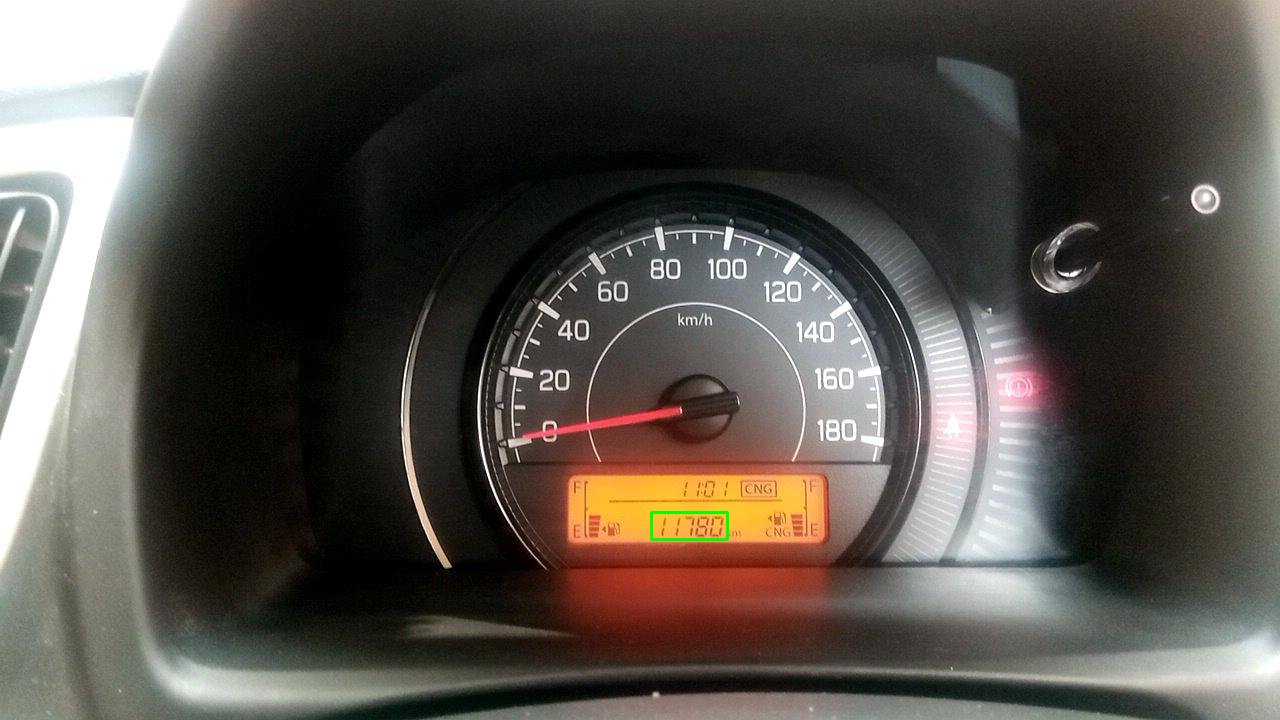

In [ ]:
image_array = cv2.rectangle(image_array, (int(pred_boxes[0][0]), int(pred_boxes[0][1])), (int(pred_boxes[0][2]), int(pred_boxes[0][3])), (0, 255, 0), 2)
Image.fromarray(image_array)

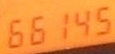

In [11]:
odometer_image